## POS tagging using modified Viterbi

### Problem Statement

- The vanilla Viterbi algorithm we had written had resulted in ~87% accuracy. 
- The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. 
- This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

You need to accomplish the following in this assignment:

- the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
- Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
- Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the  - original Viterbi POS tagger and got corrected after your modifications.

### Data Preparation

In [5]:
#Importing libraries
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk import word_tokenize
from nltk import RegexpTagger, UnigramTagger, BigramTagger
from pprint import pprint
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import time
from collections import Counter
from sklearn.model_selection import train_test_split
# incase if any libraries required Kindly run the below code:
# nltk.download()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\abdulazeez.basheerah\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdulazeez.basheerah\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

## Exploratory Data Analysis

In [7]:
print("Type of DataSet: {}".format(type(nltk_data)))
print("Type of First Element: {}".format(type(nltk_data[0])))
print("Type of First Element's Element: {}".format(type(nltk_data[0][0])))

Type of DataSet: <class 'list'>
Type of First Element: <class 'list'>
Type of First Element's Element: <class 'tuple'>


In [8]:
pprint("First Element: {}".format((nltk_data[0])))

("First Element: [('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', "
 "'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), "
 "('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', "
 "'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), "
 "('29', 'NUM'), ('.', '.')]")


<font color = 'blue'>Since all the values are in different case, will update all values to lower case

In [9]:
lower = []
for text in nltk_data:
    l = []
    for x,y in text:
        l.append((x.lower(),y.lower()))
    lower.append(l)
nltk_data = lower

In [10]:
# Getting list of tagged words
tagged_words = [tup for sent in nltk_data for tup in sent]
print(f"Length of Total Tagged words: {len(tagged_words)}\n")

# tokens 
tokens = [pair[0] for pair in tagged_words]
print(f"Sample Tokens: {tokens[:5]}\n")

# vocabulary
V = set(tokens)
print(f"Unique length of tokens: {len(V)} \n")

# number of tags
T = set([pair[1] for pair in tagged_words])
print(f"Unique length of TAGS: {len(T)}\n")

print(f"Tags: {T}")

Length of Total Tagged words: 100676

Sample Tokens: ['pierre', 'vinken', ',', '61', 'years']

Unique length of tokens: 11387 

Unique length of TAGS: 12

Tags: {'.', 'noun', 'det', 'x', 'adv', 'prt', 'verb', 'conj', 'adp', 'adj', 'num', 'pron'}


In [11]:
tag_counts = nltk.FreqDist(tag for (word, tag) in tagged_words)
print(tag_counts.most_common(5))

[('noun', 28867), ('verb', 13564), ('.', 11715), ('adp', 9857), ('det', 8725)]


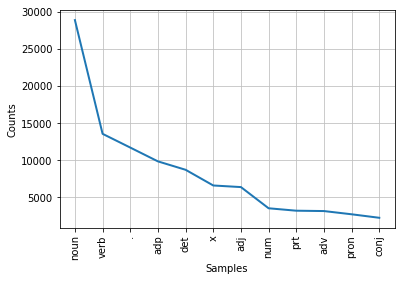

In [12]:
tag_counts.plot()

#### <font color = 'blue'> We could clearly see that most of the word belong to noun

###### <font color= 'blue'> Let's understand all the tags and look into the distribution

###### Noun:

#### <font color = 'blue'> Let's inspect some tagged text to see what parts of speech occur before a NOUN, with the most frequent ones first.

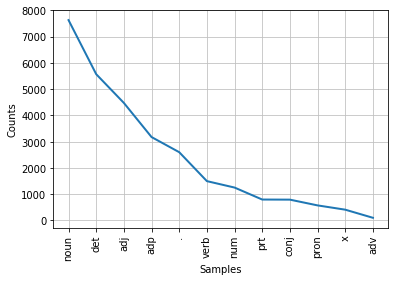

In [13]:
word_tag_pairs = nltk.bigrams(tagged_words)
noun_preceders = [a[1] for (a, b) in word_tag_pairs if b[1] == 'noun']
fdist = nltk.FreqDist(noun_preceders)
fdist.plot()

##### <font color ='blue'> This confirms our assertion that nouns occur after determiners and adjectives, including numeral adjectives (tagged as NUM).Sometimes consecutive nouns due to Names

## Verb:

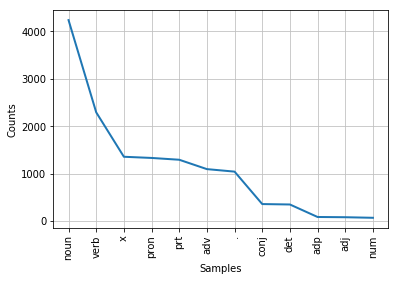

In [14]:
word_tag_pairs = nltk.bigrams(tagged_words)
verb_preceders = [a[1] for (a, b) in word_tag_pairs if b[1] == 'verb']
fdist = nltk.FreqDist(verb_preceders)
fdist.plot()

In [15]:
word_tag_fd = nltk.FreqDist(tagged_words)

cfd2 = nltk.ConditionalFreqDist((tag, word) for (word, tag) in tagged_words)

fdist = nltk.FreqDist(cfd2['verb'])
fdist.most_common(5)

[('is', 672), ('said', 628), ('was', 367), ('are', 367), ('be', 356)]

### <font color ='blue'> The above are the most common verbs in Universal Data Set

## Adjectives and Adverbs

In [16]:
word_tag_fd = nltk.FreqDist(tagged_words)

cfd2 = nltk.ConditionalFreqDist((tag, word) for (word, tag) in tagged_words)

fdist = nltk.FreqDist(cfd2['adv'])
fdist.most_common(5)

[("n't", 325), ('also', 163), ('not', 140), ('when', 98), ('more', 88)]

In [17]:
# Creating Sample Sentence
sample_corpus = []
for i in range(0, len(nltk_data)):
    temp_list = []
    for j in range(0, len(nltk_data[i])):
        temp_list.append((nltk_data[i][j][0]))
    sample_corpus.append(" ".join(temp_list))
pprint(sample_corpus[0:2])

['pierre vinken , 61 years old , will join the board as a nonexecutive '
 'director nov. 29 .',
 'mr. vinken is chairman of elsevier n.v. , the dutch publishing group .']


In [18]:
# converting the corpus into a dataFrame
temp_list_wrod = []
temp_list_tag = []
for i in range(0, len(nltk_data)):
    for j in range(0, len(nltk_data[i])):
        temp_list_wrod.append((nltk_data[i][j][0]))
        temp_list_tag.append((nltk_data[i][j][1]))
print(f"Len of WORD: {len(temp_list_wrod)}")
print(f"Len of TAG: {len(temp_list_tag)}")

Len of WORD: 100676
Len of TAG: 100676


In [19]:
corpusDF = pd.DataFrame(list(zip(temp_list_wrod, temp_list_tag)),columns =['WORD', 'TAG'])
gp = corpusDF.groupby('TAG')
count_df  = pd.DataFrame(gp['TAG'].count().reset_index(name = "count"))
count_df.sort_values(by = 'count',ascending = False, inplace = True)
count_df.dtypes

TAG      object
count     int64
dtype: object

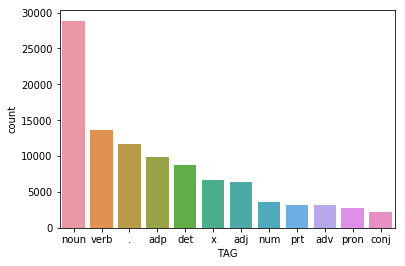

In [20]:
sns.barplot(x = 'TAG', y= 'count', data = count_df)
plt.show()

### Preprocessing Steps:

In [21]:
# Splitting into train and test
train_set, valid_set = train_test_split(nltk_data,test_size=0.05,random_state = 66)
print(f"Length of the Train Set: {len(train_set)}")
print(f"Length of the Validation Set:{len(valid_set)}")

Length of the Train Set: 3718
Length of the Validation Set:196


<font color = 'blue'> Splited Data Set into train and Test

In [22]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
print(f"Length of Train tagged Words: {len(train_tagged_words)}")

# tokens 
train_tokens = [pair[0] for pair in train_tagged_words]
print(f"Train Tokens: {train_tokens[:5]}\n")

# vocabulary
train_V = set(tokens)
print(f"Unique length of tokens: {len(train_V)}")

Length of Train tagged Words: 95662
Train Tokens: ['program', 'trading', 'critics', 'also', 'want']

Unique length of tokens: 11387


In [23]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
# choose random 5 sents

rndom = [14,69,23,105,69]
# list of sents
test_run = [valid_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

## User Defined Functions

In [24]:
def compute_stringMatirx():
    # computing P(w/t) and storing in T x V matrix
        t = len(T)
        v = len(V)
        w_given_t = np.zeros((t, v))
        
        
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag, count_tag)

# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

def createTaggedMatrix():
    # creating t x t transition matrix of tags
    tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
    for i, t1 in enumerate(list(T)):
        for j, t2 in enumerate(list(T)): 
            tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
    # convert the matrix to a df for better readability
    return pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

# to Sort the Tuples
def Sort_Tuple(tup):  
    tup.sort(key = lambda x: x[1]) 
    return tup 

# to find the incorrect words
def find_incorrectWord(tagged_seq ,test_run_base = test_run_base):
    incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
    
    # Let's check how many them are know word
    known_words = [word[1][0][0] for word in incorrect_tagged_cases  if word[1][0][0] in train_tokens]
    
    # Let's check how many them are unknow word
    unknown_words = [word[1][0][0] for word in incorrect_tagged_cases  if word[1][0][0] not in train_tokens]
    
    incorrectTags = [word for word in incorrect_tagged_cases  if word[1][0][0] not in train_tokens]
    return Sort_Tuple(incorrect_tagged_cases), known_words, unknown_words, Sort_Tuple(incorrectTags)

In [25]:
compute_stringMatirx()

tags_df = createTaggedMatrix()
tags_df

,.,noun,det,x,adv,prt,verb,conj,adp,adj,num,pron
.,0.092858,0.222950,0.172618,0.027185,0.052395,0.002512,0.089270,0.058137,0.090257,0.044231,0.080926,0.066571
noun,0.240789,0.265061,0.013557,0.029338,0.016947,0.043660,0.145887,0.042494,0.176282,0.011844,0.009621,0.004519
det,0.018094,0.636188,0.005549,0.046080,0.013028,0.000241,0.039324,0.000483,0.009530,0.204825,0.023040,0.003619
x,0.164497,0.062877,0.053668,0.074944,0.025405,0.184344,0.204351,0.010480,0.144649,0.016990,0.002858,0.054938
adv,0.133887,0.031561,0.069103,0.022924,0.078738,0.014618,0.349169,0.006977,0.118605,0.129568,0.029568,0.015282
prt,0.042623,0.246885,0.099344,0.013443,0.009836,0.001311,0.402295,0.001967,0.020328,0.085574,0.058361,0.018033
verb,0.034563,0.109903,0.134835,0.218097,0.082097,0.031146,0.168854,0.005515,0.090563,0.065476,0.022990,0.035961
conj,0.035332,0.349140,0.118550,0.007438,0.054393,0.005114,0.156671,0.000465,0.054393,0.117620,0.041841,0.059042
adp,0.039581,0.320817,0.325631,0.034767,0.013265,0.001391,0.008023,0.000856,0.017330,0.106975,0.062687,0.068678
adj,0.064277,0.699819,0.005096,0.021207,0.004603,0.010521,0.011836,0.016439,0.077758,0.067072,0.020713,0.000658


### Build the vanilla Viterbi without handling unknown words

In [26]:
# Venila Viterbi Heuristic
def venila_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p 
            p.append(state_probability)
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [27]:
# tagging the test sentences
start = time.time()
venila_tagged_seq = venila_Viterbi(test_tagged_words)
end = time.time()
print("Time taken in seconds: ", end - start)

Time taken in seconds:  60.70968151092529


#### Evaluating tagging accuracy in Venila Viterbi

In [28]:
# accuracy
check = [i for i, j in zip(venila_tagged_seq, test_run_base) if i == j] 
venila_accuracy = len(check)/len(venila_tagged_seq)
print(f"Accuracy of valid data in Venila Viterbi: {round(venila_accuracy *100,2)}")

Accuracy of valid data in Venila Viterbi: 89.62


In [29]:
venila_incrrocet_Words,venila_known_words,venila_unknown_words,venila_unknown_tags = find_incorrectWord(venila_tagged_seq)

print("Words which are know and tagged incorrectly: \n",venila_known_words,"\n")

print("Words which are unknown and tagged incorrectly: \n",venila_unknown_words,"\n")

Words which are know and tagged incorrectly: 
 ['earlier', 'that'] 

Words which are unknown and tagged incorrectly: 
 ['adopting', 'training-wage', 'diming', 'conn.based', 'magnified', 'nonrecurring', '8.2', 'asset-valuation', 'adjustments', '6.4', 'pre-tax', 'conn.based', 'magnified', 'nonrecurring', '8.2', 'asset-valuation', 'adjustments'] 



<font color = 'blue'> These are the words which are tagged incorrectly

### <font color = 'blue'> Let's update the venila viterbi and see how it performs for unknown words

## Method 1 : Using Only Transition Probability for Viterbi to handle unknown words

In [30]:
# Viterbi Heuristic with Only Transition Probablity for unknown Words 
def unknow_Trans_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        transP =[]
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p 
            p.append(state_probability)
 # Creating list of Transaction Probability
            transP.append(transition_p)
 # calculating only if emission_p is Greater then zero 
 # Else we will use only Transition Probability    
        pmax = max(p)
        if pmax == 0:
            pmax = max(transP)
            state_max = T[transP.index(pmax)]
        else:
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [31]:
# tagging the test sentences
start = time.time()
unknow_trans_seq = unknow_Trans_Viterbi(test_tagged_words)
end = time.time()
print("Time taken in seconds: ", end - start)

Time taken in seconds:  60.75867819786072


#### Evaluating tagging accuracy after using transition Probability

In [32]:
# accuracy
check = [i for i, j in zip(unknow_trans_seq, test_run_base) if i == j] 
trans_accuracy = len(check)/len(unknow_trans_seq)

print(f"Accuracy of valid data after using transcition Probability: {round(trans_accuracy *100,2)}")
print(f"Increase in the Accuracy: {round((trans_accuracy - venila_accuracy)*100 ,2)}")

Accuracy of valid data after using transcition Probability: 91.8
Increase in the Accuracy: 2.19


In [33]:
trans_incorrect_Words,trans_known_words,trans_unknown_words,trans_unknown_tags = find_incorrectWord(unknow_trans_seq)
trans_incorrect_Words

[[('$', '.'), (('6.4', 'noun'), ('6.4', 'num'))],
 [('$', '.'), (('8.2', 'noun'), ('8.2', 'num'))],
 [('$', '.'), (('8.2', 'noun'), ('8.2', 'num'))],
 [('in', 'adp'), (('asset-valuation', 'det'), ('asset-valuation', 'noun'))],
 [('in', 'adp'), (('asset-valuation', 'det'), ('asset-valuation', 'noun'))],
 [(',', '.'), (('conn.based', 'noun'), ('conn.based', 'adj'))],
 [(',', '.'), (('conn.based', 'noun'), ('conn.based', 'adj'))],
 [('year', 'noun'), (('earlier', 'adv'), ('earlier', 'adj'))],
 [('was', 'verb'), (('magnified', 'x'), ('magnified', 'verb'))],
 [('was', 'verb'), (('magnified', 'x'), ('magnified', 'verb'))],
 [('by', 'adp'), (('nonrecurring', 'det'), ('nonrecurring', 'verb'))],
 [('by', 'adp'), (('nonrecurring', 'det'), ('nonrecurring', 'verb'))],
 [('fourth-quarter', 'noun'), (('pre-tax', 'noun'), ('pre-tax', 'adj'))],
 [('estimated', 'verb'), (('that', 'det'), ('that', 'adp'))],
 [('a', 'det'), (('training-wage', 'noun'), ('training-wage', 'adj'))]]

<font color = 'blue'> These are the words which are tagged incorrectly after using Transition Porbability

In [34]:
print("Words which are know and tagged incorrectly: \n",trans_known_words,"\n")

print("Words which are unknown and tagged incorrectly: \n",trans_unknown_words,"\n")


Words which are know and tagged incorrectly: 
 ['earlier', 'that'] 

Words which are unknown and tagged incorrectly: 
 ['training-wage', 'conn.based', 'magnified', 'nonrecurring', '8.2', 'asset-valuation', '6.4', 'pre-tax', 'conn.based', 'magnified', 'nonrecurring', '8.2', 'asset-valuation'] 



## Method 2 : Rule Based:

#### <font color = 'blue'> Will take first three sufix and create rules

In [35]:
for tag in T:
    temp_counts = Counter([pair[0][-3:] for pairs in nltk_data for pair in pairs if pair[1]==tag])
    print(tag,temp_counts.most_common(5))

. [(',', 4885), ('.', 3828), ('$', 718), ('``', 702), ("''", 684)]
noun [('ion', 1083), ('ers', 848), ('ing', 831), ('ent', 778), ('ons', 486)]
det [('the', 4753), ('a', 1979), ('an', 335), ('hat', 334), ('his', 224)]
x [('*-1', 2068), ('0', 1099), ('*', 965), ('*-2', 766), ('*u*', 744)]
adv [("n't", 325), ('lly', 204), ('lso', 163), ('tly', 159), ('not', 140)]
prt [('to', 2179), ("'s", 761), ('up', 77), ("'", 63), ('out', 50)]
verb [('ing', 1476), ('is', 672), ('aid', 653), ('ted', 617), ('are', 381)]
conj [('and', 1549), ('but', 307), ('or', 294), ('&', 85), ('nor', 12)]
adp [('of', 2325), ('in', 1749), ('for', 851), ('hat', 514), ('on', 500)]
adj [('her', 202), ('ent', 189), ('ing', 186), ('ble', 185), ('ive', 177)]
num [('ion', 547), ('000', 152), ('one', 140), ('two', 109), ('500', 54)]
pron [('it', 577), ('its', 343), ('he', 303), ('hey', 263), ('eir', 184)]


### used above observation to create Rules for Regex Tagger

In [36]:
# Regex Tagger
def regexTag(word):
    patterns = [(r'.*ion$', 'noun'),(r'.*ers$', 'noun'),(r'.*-[0-9]$', 'noun'),     
                (r'.*ing$', 'verb'),(r'.*is$', 'verb'),(r'.*ed$', 'verb'),
                (r'.*to$', 'prt'),(r'.*and$', 'conj'),(r'.*or$', 'conj'),
                (r'.*of$', 'adp'),(r'.*hat$', 'det'),(r'.*her$', 'adj'),(r'.*ent$', 'noun'),(r'.*\'t$', 'adj'),
                (r'^-?[0-9]+(.[0-9]+)?$', 'num'),(r'.*[0-9]$', 'x'),(r'.*[0-9]', 'num'),(r'.*', 'noun')]
    
    # we have defined a general Rule for words which are not satisfying the above rules, will be assgined to the noun tag
        # since noun is the most probabale TAG
        
    regexp_tagger = nltk.RegexpTagger(patterns)
    return regexp_tagger.tag([word])[0][1]

In [37]:
def ruleBased_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p 
            p.append(state_probability)
        pmax = max(p)
        # To Handle unknown words
        if pmax == 0:
            state_max = regexTag(word)
        else:
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state)) 

In [38]:
# tagging the test sentences
start = time.time()
tagged_seq_ruleBased = ruleBased_Viterbi(test_tagged_words)
end = time.time()

#### Evaluating tagging accuracy of Rule Based Tagger

In [39]:
# accuracy
check = [i for i, j in zip(tagged_seq_ruleBased, test_run_base) if i == j] 
rule_accuracy = len(check)/len(tagged_seq_ruleBased)

print(f"Time taken in seconds: {end-start}")
print(f"Accuracy of valid data after Rule Based Models: {round(rule_accuracy *100,2)}")
print(f"Increase in the Accuracy: {round((rule_accuracy - venila_accuracy)*100 ,2)}")

Time taken in seconds: 62.32636213302612
Accuracy of valid data after Rule Based Models: 96.17
Increase in the Accuracy: 6.56


In [40]:
rule_incrrocet_Words,rule_known_words,rule_unknown_words,rule_unknown_tags = find_incorrectWord(tagged_seq_ruleBased)

rule_incrrocet_Words

[[(',', '.'), (('conn.based', 'verb'), ('conn.based', 'adj'))],
 [(',', '.'), (('conn.based', 'verb'), ('conn.based', 'adj'))],
 [('and', 'conj'), (('diming', 'verb'), ('diming', 'noun'))],
 [('year', 'noun'), (('earlier', 'adv'), ('earlier', 'adj'))],
 [('fourth-quarter', 'noun'), (('pre-tax', 'noun'), ('pre-tax', 'adj'))],
 [('estimated', 'verb'), (('that', 'det'), ('that', 'adp'))],
 [('a', 'det'), (('training-wage', 'noun'), ('training-wage', 'adj'))]]

<font color = 'blue'> These are the words which are tagged incorrectly

In [41]:
print("Words which are know and tagged incorrectly: \n",rule_known_words,"\n")

print("Words which are unknown and tagged incorrectly: \n",rule_unknown_words,"\n")


Words which are know and tagged incorrectly: 
 ['earlier', 'that'] 

Words which are unknown and tagged incorrectly: 
 ['training-wage', 'diming', 'conn.based', 'pre-tax', 'conn.based'] 



In [42]:
print("Words which are unknown and tagged incorrectly: \n")
pprint(Sort_Tuple(rule_unknown_tags))

Words which are unknown and tagged incorrectly: 

[[(',', '.'), (('conn.based', 'verb'), ('conn.based', 'adj'))],
 [(',', '.'), (('conn.based', 'verb'), ('conn.based', 'adj'))],
 [('and', 'conj'), (('diming', 'verb'), ('diming', 'noun'))],
 [('fourth-quarter', 'noun'), (('pre-tax', 'noun'), ('pre-tax', 'adj'))],
 [('a', 'det'), (('training-wage', 'noun'), ('training-wage', 'adj'))]]


### Compare the tagging accuracies after handling unknown words of  the vanilla Viterbi algorithm

In [43]:
print(f" Accuracy of Venila Viterbi Algo: {round(venila_accuracy*100,2)}\n"
      ,f"Accuracy of Viterbi based on Transition Prob: {round(trans_accuracy*100,2)}\n"
       ,f"Accuracy of Viterbi based on Rule Based:{round(rule_accuracy*100,2)}")

 Accuracy of Venila Viterbi Algo: 89.62
 Accuracy of Viterbi based on Transition Prob: 91.8
 Accuracy of Viterbi based on Rule Based:96.17


## <font color = ' blue'>We could see there is difference in the Accuracy of venila and modified viterbi and Rule Based on validation Set

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [44]:
# Words which are tagged wrongly / unknown in viterbi and corrected on Transition probability
wrds_correctedByTrans = set(venila_unknown_words) - set(trans_unknown_words)
wrds_correctedByTrans

{'adjustments', 'adopting', 'diming'}

In [45]:
wrds_correctedByRule = set(venila_unknown_words) - set(rule_unknown_words)
wrds_correctedByRule

{'6.4',
 '8.2',
 'adjustments',
 'adopting',
 'asset-valuation',
 'magnified',
 'nonrecurring'}

### Sample Test Evaluation

In [46]:
# Read input file for test sample
text = open('Test_sentences.txt', 'r').read()

In [47]:
tagged = []
sent_text = nltk.sent_tokenize(text) # this gives us a list of sentences
# now loop over each sentence and tokenize it separately
for sentence in sent_text:
    tokenized_text = nltk.word_tokenize(sentence)
    inner_list = nltk.pos_tag(tokenized_text,tagset='universal')
    tagged.append(inner_list)

In [48]:
#Change to lowercase
lower = []
for a in tagged:
    l = []
    for x,y in a:
        l.append((x.lower(),y.lower()))
    lower.append(l)
tagged_lower = lower

In [49]:
# tagging the test sentences
# list of tagged words
sample_run_base = [tup for sent in tagged_lower for tup in sent]

# list of untagged words
sample_tagged_words = [tup[0] for sent in tagged_lower for tup in sent]

### Running Venila Viterbi On Sample Test File

In [50]:
# tagging the test sentences
start = time.time()
sample_venila_tagged_seq = venila_Viterbi(sample_tagged_words)
end = time.time()
print("Time taken in seconds: ", end - start)

Time taken in seconds:  58.497602224349976


#### Evaluating tagging accuracy in Venila Viterbi

In [51]:
# accuracy
check = [i for i, j in zip(sample_venila_tagged_seq, sample_run_base) if i == j] 
sample_venila_accuracy = len(check)/len(sample_venila_tagged_seq)
print(f"Accuracy of valid data in Venila Viterbi: {round(sample_venila_accuracy *100,2)}")

Accuracy of valid data in Venila Viterbi: 75.14


In [52]:
sample_venila_incrrocet_Words,sample_venila_known_words,sample_venila_unknown_words,sample_venila_unknown_tags = find_incorrectWord(sample_venila_tagged_seq,sample_run_base)

print("Words which are know and tagged incorrectly: \n",sample_venila_known_words,"\n")

print("Words which are unknown and tagged incorrectly: \n",sample_venila_unknown_words,"\n")

Words which are know and tagged incorrectly: 
 ['that', "'s", 'international', '11th', 'show', 'like', 'show', 'about', 'experience'] 

Words which are unknown and tagged incorrectly: 
 ['android', 'google', 'android', 'os', 'worldwide', 'smartphones', '2011', '2013', 'google', 'twitter', '2015', 'google', 'twitter', 'firehose', 'twitter', 'online', 'interact', 'messages', 'tweets', 'domineering', 'personality', '2018', 'fifa', 'cup', '21st', 'fifa', 'cup', 'tournament', 'contested', 'cup', 'trips', 'arriving', 'nasa', 'invited', 'icesat-2', 'satellite'] 



<font color = 'blue'> These are the words which are tagged incorrectly

## viterbi based on Transition Probability

In [53]:
# tagging the test sentences
start = time.time()
sample_unknow_trans_seq = unknow_Trans_Viterbi(sample_tagged_words)
end = time.time()
print("Time taken in seconds: ", end - start)

Time taken in seconds:  58.93448853492737


#### Evaluating tagging accuracy after using transition Probability

In [54]:
# accuracy
check = [i for i, j in zip(sample_unknow_trans_seq, sample_run_base) if i == j] 
sample_trans_accuracy = len(check)/len(sample_unknow_trans_seq)

print(f"Accuracy of valid data after using transcition Probability: {round(sample_trans_accuracy *100,2)}")
print(f"Increase in the Accuracy: {round((sample_trans_accuracy - sample_venila_accuracy)*100 ,2)}")

Accuracy of valid data after using transcition Probability: 86.19
Increase in the Accuracy: 11.05


In [55]:
sample_trans_incorrect_Words,sample_trans_known_words,sample_trans_unknown_words,sample_trans_unknown_tags = find_incorrectWord(sample_unknow_trans_seq,sample_run_base)
sample_trans_incorrect_Words

[[('the', 'det'), (('11th', 'adj'), ('11th', 'num'))],
 [('since', 'adp'), (('2011', 'det'), ('2011', 'num'))],
 [('since', 'adp'), (('2013', 'det'), ('2013', 'num'))],
 [('in', 'adp'), (('2015', 'det'), ('2015', 'num'))],
 [('the', 'det'), (('2018', 'noun'), ('2018', 'num'))],
 [('the', 'det'), (('21st', 'noun'), ('21st', 'num'))],
 [('at', 'adp'), (('about', 'adp'), ('about', 'adv'))],
 [('tournament', 'noun'), (('contested', 'noun'), ('contested', 'verb'))],
 [('a', 'det'), (('domineering', 'noun'), ('domineering', 'adj'))],
 [('to', 'prt'), (('experience', 'noun'), ('experience', 'verb'))],
 [("'s", 'prt'), (('firehose', 'verb'), ('firehose', 'noun'))],
 [('by', 'adp'), (('google', 'det'), ('google', 'noun'))],
 [('gave', 'verb'), (('google', 'x'), ('google', 'noun'))],
 [('of', 'adp'), (('icesat-2', 'det'), ('icesat-2', 'noun'))],
 [('an', 'det'), (('international', 'noun'), ('international', 'adj'))],
 [('nasa', 'noun'), (('invited', 'noun'), ('invited', 'verb'))],
 [('would', 'v

<font color = 'blue'> These are the words which are tagged incorrectly after using Transition Porbability

In [56]:
print("Words which are know and tagged : \n",sample_trans_known_words,"\n")

print("Words which are unknown and tagged incorrectly: \n",sample_trans_unknown_words,"\n")

Words which are know and tagged : 
 ['that', 'international', '11th', 'show', 'like', 'show', 'about', 'experience'] 

Words which are unknown and tagged incorrectly: 
 ['google', 'smartphones', '2011', '2013', '2015', 'google', 'twitter', 'firehose', 'online', 'messages', 'tweets', 'domineering', '2018', '21st', 'contested', 'invited', 'icesat-2'] 



## viterbi Based On Rules

In [57]:
# tagging the test sentences
start = time.time()
sample_tagged_seq_ruleBased = ruleBased_Viterbi(sample_tagged_words)
end = time.time()
print("Time taken in seconds: ", end - start)

Time taken in seconds:  58.845736026763916


#### Evaluating tagging accuracy of Rule Based Tagger

In [58]:
# accuracy
check = [i for i, j in zip(sample_tagged_seq_ruleBased, sample_run_base) if i == j] 
sample_rule_accuracy = len(check)/len(sample_tagged_seq_ruleBased)

print(f"Time taken in seconds: {end-start}")
print(f"Accuracy of valid data after Rule Based Models: {round(sample_rule_accuracy *100,2)}")
print(f"Increase in the Accuracy: {round((sample_rule_accuracy - sample_venila_accuracy)*100 ,2)}")

Time taken in seconds: 58.845736026763916
Accuracy of valid data after Rule Based Models: 93.92
Increase in the Accuracy: 18.78


In [59]:
sample_rule_incrrocet_Words,sample_rule_known_words,sample_rule_unknown_words,sample_rule_unknown_tags = find_incorrectWord(sample_tagged_seq_ruleBased,sample_run_base)

sample_rule_incrrocet_Words

[[('the', 'det'), (('11th', 'adj'), ('11th', 'num'))],
 [('at', 'adp'), (('about', 'adp'), ('about', 'adv'))],
 [('and', 'conj'), (('arriving', 'verb'), ('arriving', 'noun'))],
 [('a', 'det'), (('domineering', 'verb'), ('domineering', 'adj'))],
 [('to', 'prt'), (('experience', 'noun'), ('experience', 'verb'))],
 [('an', 'det'), (('international', 'noun'), ('international', 'adj'))],
 [('would', 'verb'), (('like', 'adp'), ('like', 'verb'))],
 [('an', 'det'), (('online', 'noun'), ('online', 'adj'))],
 [('.', '.'), (('show', 'noun'), ('show', 'verb'))],
 [('.', '.'), (('show', 'noun'), ('show', 'verb'))],
 [('2015', 'num'), (('that', 'adp'), ('that', 'det'))]]

<font color = 'blue'> These are the words which are tagged incorrectly

In [60]:
print("Words which are know and tagged incorrectly: \n",sample_rule_known_words,"\n")

print("Words which are unknown and tagged incorrectly: \n",sample_rule_unknown_words,"\n")

Words which are know and tagged incorrectly: 
 ['that', 'international', '11th', 'show', 'like', 'show', 'about', 'experience'] 

Words which are unknown and tagged incorrectly: 
 ['online', 'domineering', 'arriving'] 



### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [61]:
print(f" Accuracy of Venila Viterbi Algo: {round(sample_venila_accuracy*100,2)}\n"
      ,f"Accuracy of Viterbi based on Transition Prob: {round(sample_trans_accuracy*100,2)}\n"
       ,f"Accuracy of Viterbi based on Rule Based:{round(sample_rule_accuracy*100,2)}")

 Accuracy of Venila Viterbi Algo: 75.14
 Accuracy of Viterbi based on Transition Prob: 86.19
 Accuracy of Viterbi based on Rule Based:93.92


## <font color = ' blue'>We could see there is difference in the Accuracy of venila and modified viterbi and Rule Based on Sample / Test Set

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [62]:
# Words which are tagged wrongly / unknown in viterbi and corrected on Transition probability
sample_wrds_correctedByTrans = set(sample_venila_unknown_words) - set(sample_trans_unknown_words)
sample_wrds_correctedByTrans

{'android',
 'arriving',
 'cup',
 'fifa',
 'interact',
 'nasa',
 'os',
 'personality',
 'satellite',
 'tournament',
 'trips',
 'worldwide'}

In [63]:
sample_wrds_correctedByRule = set(sample_venila_unknown_words) - set(sample_rule_unknown_words)
sample_wrds_correctedByRule

{'2011',
 '2013',
 '2015',
 '2018',
 '21st',
 'android',
 'contested',
 'cup',
 'fifa',
 'firehose',
 'google',
 'icesat-2',
 'interact',
 'invited',
 'messages',
 'nasa',
 'os',
 'personality',
 'satellite',
 'smartphones',
 'tournament',
 'trips',
 'tweets',
 'twitter',
 'worldwide'}